Rossiter-McLaughlin Effect
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.2 installed. (You can comment out this line if you don't use pip for your installation or don't want to update to the latest release).

In [ ]:
!pip install -I "phoebe>=2.2,<2.3"

In [1]:
%matplotlib inline

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.ipynb) for more details.

In [1]:
import phoebe
import numpy as np

b = phoebe.default_binary()

Now we'll try to exaggerate the effect by spinning up the secondary component.

In [2]:
b.set_value('q', value=0.7)
b.set_value('incl', component='binary', value=87)
b.set_value('requiv', component='primary', value=0.8)
b.set_value('teff', component='secondary', value=6500)
b.set_value('syncpar', component='secondary', value=1.5)

Adding Datasets
-------------------

We'll add radial velocity, line profile, and mesh datasets.  We'll compute the rvs through the whole orbit, but the mesh and line profiles right around the eclipse - just at the times that we want to plot for an animation.

In [3]:
anim_times = phoebe.arange(0.44, 0.56, 0.002)

We'll add two identical datasets, one where we compute only dynamical RVs (won't include Rossiter-McLaughlin) and another where we compute flux-weighted RVs (will include Rossiter-McLaughlin).

In [4]:
b.add_dataset('rv', 
              times=phoebe.linspace(0,1,201), 
              dataset='dynamicalrvs')

b.set_value_all('rv_method', dataset='dynamicalrvs', value='dynamical')

In [5]:
b.add_dataset('rv', 
              times=phoebe.linspace(0,1,201), 
              dataset='numericalrvs')

b.set_value_all('rv_method', dataset='numericalrvs', value='flux-weighted')

For the mesh, we'll save some time by only exposing plane-of-sky coordinates and the 'rvs' column.

In [6]:
b.add_dataset('mesh', 
              compute_times=anim_times, 
              coordinates='uvw', 
              columns=['rvs@numericalrvs'],
              dataset='mesh01')

<ParameterSet: 7 parameters | contexts: dataset, compute, constraint>

And for the line-profile, we'll expose the line-profile for both of our stars separately, instead of for the entire system.

In [7]:
b.add_dataset('lp', 
              compute_times=anim_times, 
              component=['primary', 'secondary'], 
              wavelengths=phoebe.linspace(549.5,550.5,101), 
              profile_rest=550)

<ParameterSet: 14 parameters | contexts: dataset, compute, constraint>

Running Compute
--------------------

In [8]:
b.run_compute(irrad_method='none')

<ParameterSet: 500 parameters | kinds: rv, mesh, lp>

Plotting 
---------------

Throughout all of these plots, we'll color the components green and magenta (to differentiate them from the red and blue of the RV mapping).

In [9]:
colors = {'primary': 'green', 'secondary': 'magenta'}

First let's compare between the dynamical and numerical RVs.  

The dynamical RVs show the velocity of the center of each star along the line of sight.  But the numerical method integrates over the visible surface elements, giving us what we'd observe if deriving RVs from observed spectra of the binary.  Here we do see the Rossiter McLaughlin effect.  You'll also notice that RVs are not available for the secondary star when its completely occulted (they're nans in the array).

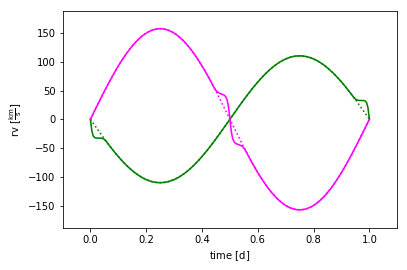

In [10]:
afig, mplfig = b.plot(kind='rv',
                      c=colors, 
                      ls={'numericalrvs': 'solid', 'dynamicalrvs': 'dotted'},
                      show=True)

Now let's make a plot of the line profiles and mesh during ingress to visualize what's happening. 

Let's go through these options:
* `time`: make the plot at this single time
* `fc`: (will be ignored by everything but the mesh): set the facecolor to the rvs column.  This will automatically apply a red-blue color mapping.
* `ec`: disable drawing the edges of the triangles in a separate color.  We could also set this to 'none', but then we'd be able to "see-through" the triangle edges.
* `c`: set the colors as defined in our dictionary above.  This will apply to the rv, lp, and horizon datasets, but will be ignored by the mesh.
* `ls`: set the linestyle to differentiate between numerical and dynamical rvs.
* `highlight`: highlight the current time on the numerical rvs only.
* `axpos`: define the layout of the axes so the mesh plot takes up the horizontal space it needs.
* `xlim`: "zoom-in" on the RM effect in the RVs, allow the others to fallback on automatic limits.
* `tight_layout`: use matplotlib's tight layout to ensure we have enough padding between axes to see the labels.

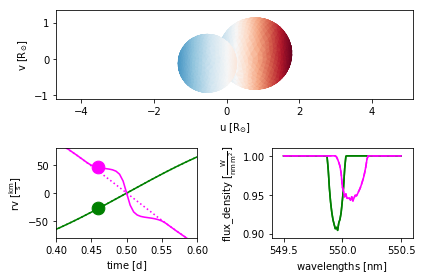

In [11]:
afig, mplfig= b.plot(time=0.46,
                     fc='rvs@numericalrvs', ec='face',
                     c=colors,
                     ls={'numericalrvs': 'solid', 'dynamicalrvs': 'dotted'},
                     highlight={'numericalrvs': True, 'dynamicalrvs': False},
                     axpos={'mesh': 211, 'rv': 223, 'lp': 224},
                     xlim={'rv': (0.4, 0.6)}, ylim={'rv': (-80, 80)},
                     tight_layout=True, 
                     show=True)

Here we can see that star in front (green) is eclipsing more of the blue-shifted part of the back star (magenta), distorting the line profile, causing the apparent center of the line profile to be shifted to the right/red, and therefore the radial velocities to be articially increased as compared to the dynamical RVs.

Now let's animate the same figure in time.  We'll use the same arguments as the static plot above, with the following exceptions:

* `times`: pass our array of times that we want the animation to loop over.
* `pad_aspect`: pad_aspect doesn't work with animations, so we'll disable to avoid the warning messages.
* `animate`: self-explanatory.
* `save`: we could use `show=True`, but that doesn't always play nice with jupyter notebooks
* `save_kwargs`: may need to change these for your setup, to create a gif, passing {'writer': 'imagemagick'} is often useful.

/home/kyle/.local/lib/python2.7/site-packages/phoebe/dependencies/nparray/nparray.py:360: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.array, operator)(other)


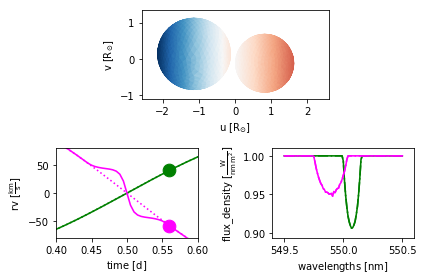

In [12]:
afig, mplanim = b.plot(times=anim_times,
                       fc='rvs@numericalrvs', ec='face',
                       c=colors,
                       ls={'numericalrvs': 'solid', 'dynamicalrvs': 'dotted'},
                       highlight={'numericalrvs': True, 'dynamicalrvs': False},
                       tight_layout=True, pad_aspect=False,
                       axpos={'mesh': 211, 'rv': 223, 'lp': 224},
                       xlim={'rv': (0.4, 0.6)}, ylim={'rv': (-80, 80)},
                       animate=True, 
                       save='rossiter_mclaughlin.gif',
                       save_kwargs={'writer': 'imagemagick'})

![rm animation](rossiter_mclaughlin.gif)